# Proyek Klasifikasi Gambar: Drowsiness Detection Dataset

## Import Semua Packages/Library yang Digunakan

In [ ]:
import os
import shutil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm as tq

In [ ]:
# Libraries untuk pemrosesan data gambar
import cv2
from PIL import Image

In [ ]:
# Libraries untuk pembangunan model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


## Data Preparation

### Data Loading

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
#!/bin/bash
!kaggle datasets download -d hazemfahmy/openned-closed-eyes

Dataset URL: https://www.kaggle.com/datasets/hazemfahmy/openned-closed-eyes
License(s): apache-2.0
 98% 515M/526M [00:01<00:00, 289MB/s]
100% 526M/526M [00:01<00:00, 329MB/s]


In [ ]:
!unzip openned-closed-eyes.zip

Streaming output truncated to the last 5000 lines.
  inflating: TestSet_json/TestSet_json/4419.json  
  inflating: TestSet_json/TestSet_json/44194.json  
  inflating: TestSet_json/TestSet_json/44195.json  
  inflating: TestSet_json/TestSet_json/44208.json  
  inflating: TestSet_json/TestSet_json/4424.json  
  inflating: TestSet_json/TestSet_json/44241.json  
  inflating: TestSet_json/TestSet_json/44246.json  
  inflating: TestSet_json/TestSet_json/4425.json  
  inflating: TestSet_json/TestSet_json/44271.json  
  inflating: TestSet_json/TestSet_json/44286.json  
  inflating: TestSet_json/TestSet_json/44294.json  
  inflating: TestSet_json/TestSet_json/4430.json  
  inflating: TestSet_json/TestSet_json/4431.json  
  inflating: TestSet_json/TestSet_json/44331.json  
  inflating: TestSet_json/TestSet_json/44340.json  
  inflating: TestSet_json/TestSet_json/44341.json  
  inflating: TestSet_json/TestSet_json/44354.json  
  inflating: TestSet_json/TestSet_json/44355.json  
  inflating: TestS

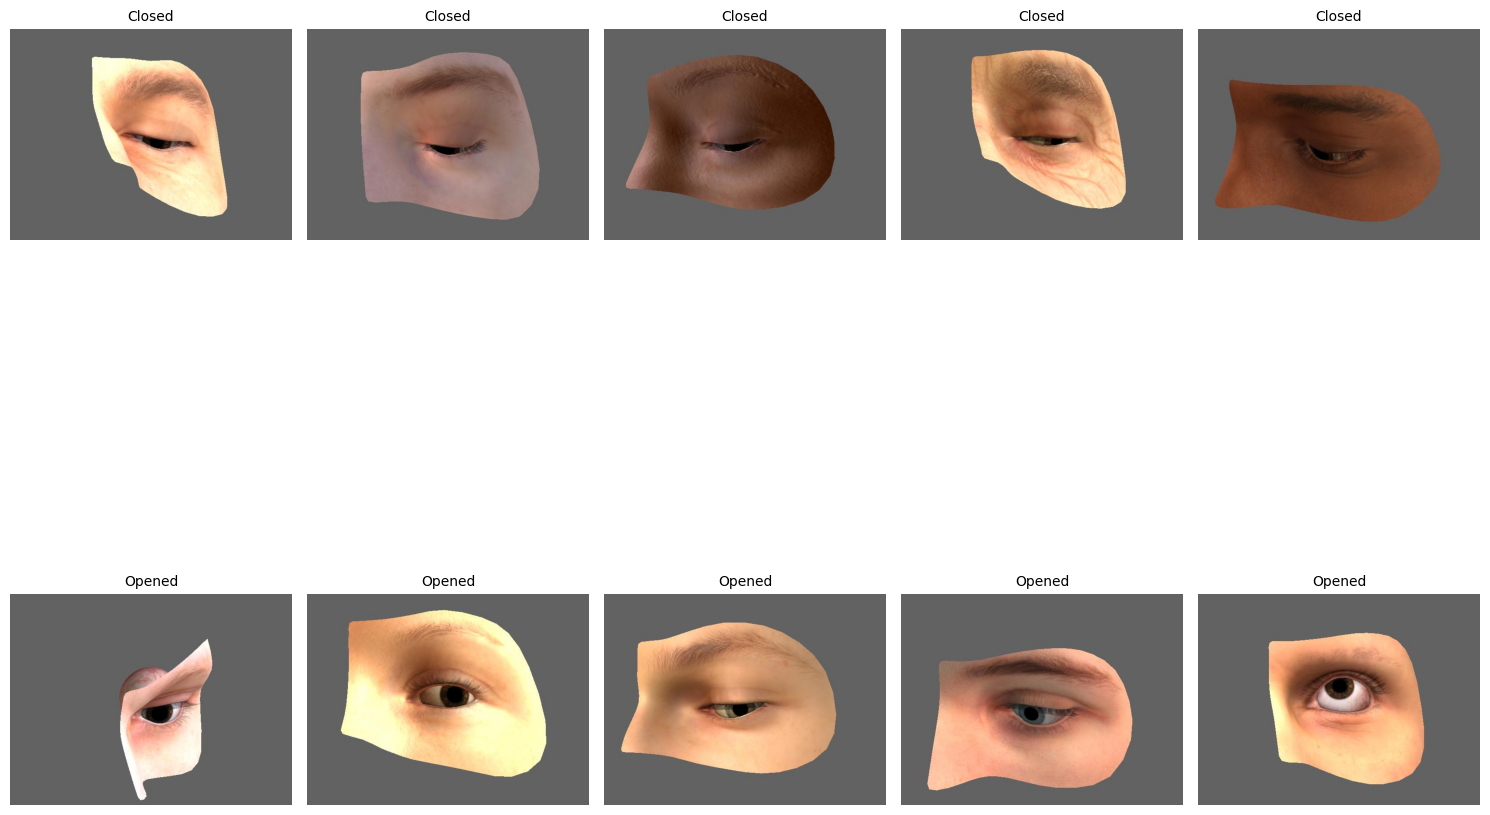

In [ ]:
dataset_path = "ImprovementSet/ImprovementSet/ImprovementSet"

# Membuat kamus yang menyimpan daftar gambar untuk setiap kelas
drowsiness_image = {}

# Mengambil daftar kelas dari folder dataset
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)

    # Hanya folder yang diproses
    if os.path.isdir(class_path):
        image_list = os.listdir(class_path)

        # Hanya gambar yang diproses (hindari folder kosong)
        if len(image_list) >= 5:
            drowsiness_image[class_name] = image_list

# Menampilkan secara acak 5 gambar dari setiap kelas (2 kelas)
num_classes = min(2, len(drowsiness_image))  # Ambil 2 kelas
fig, axs = plt.subplots(num_classes, 5, figsize=(15, 15))

# Looping untuk menampilkan gambar dari setiap kelas
for i, (class_name, images) in enumerate(drowsiness_image.items()):
    if i >= 2:  # Batasi hanya 2 kelas
        break

    # 5 gambar secara acak dari kelas
    selected_images = np.random.choice(images, 5, replace=False)

    for j, image_name in enumerate(selected_images):
        img_path = os.path.join(dataset_path, class_name, image_name)

        try:
            # Buka gambar dan konversi ke grayscale
            img = Image.open(img_path).convert("RGB")

            # Tampilkan gambar
            axs[i, j].imshow(img, cmap='gray')
            axs[i, j].set_title(class_name, fontsize=10)
            axs[i, j].axis("off")  # Hilangkan axis/ticks
        except Exception as e:
            print(f"Error membuka gambar {img_path}: {e}")

# Rapikan tampilan
plt.tight_layout()
plt.show()

In [ ]:
# Iterasi tiap folder kelas dan hitung jumlah file di dalamnya
for class_name in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_path):
        total_files = len([f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))])
        print(f"{class_name}: {total_files} file")

Closed: 1932 file
Opened: 2171 file


In [ ]:
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)
        image_files = os.listdir(subdir_path)
        num_images = len(image_files)
        print(f"{subdir}: {num_images}")
        total_images += num_images

        for img_file in image_files:
            img_path = os.path.join(subdir_path, img_file)
            with Image.open(img_path) as img:
                unique_sizes.add(img.size)

        for size in unique_sizes:
            print(f"- {size}")
        print("---------------")

    print(f"\nTotal: {total_images}")
print_images_resolution(dataset_path)

Closed: 1932
- (640, 480)
---------------
Opened: 2171
- (640, 480)
---------------

Total: 4103


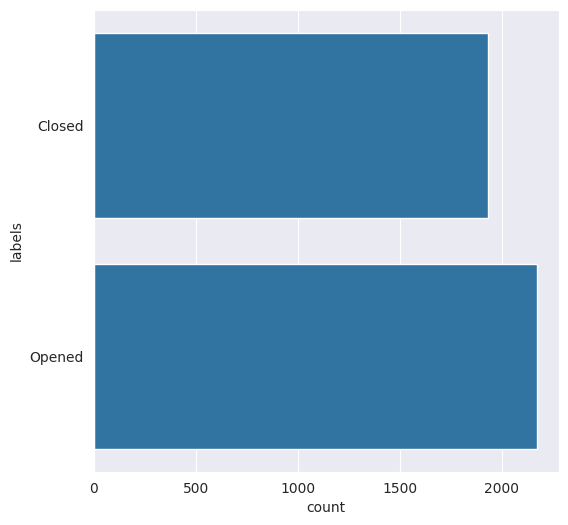

In [ ]:
# Buat daftar yang menyimpan data untuk setiap nama file, path file, dan label dalam data
file_name = []
labels = []
full_path = []

# Dapatkan nama file gambar, path file, dan label satu per satu dengan looping, dan simpan sebagai dataframe
for path, subdirs, files in os.walk(dataset_path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path, 'file_name':file_name, "labels":labels})

# Plot distribusi gambar di setiap kelas
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

### Data Preprocessing

#### Split Dataset

In [ ]:
# Path asal
base_path = "ImprovementSet/ImprovementSet/ImprovementSet"
output_base = "dataset_split"  # folder output
classes = ['Closed', 'Opened']
test_size = 0.2  # 20% test

# Membuat folder output
for split in ['train', 'test']:
    for class_name in classes:
        os.makedirs(os.path.join(output_base, split, class_name), exist_ok=True)

# Memproses tiap kelas
for class_name in classes:
    class_path = os.path.join(base_path, class_name)
    images = os.listdir(class_path)

    # Bagi train dan test
    train_images, test_images = train_test_split(images, test_size=test_size, random_state=42)

    # Salin ke folder train
    for img in train_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(output_base, 'train', class_name, img)
        shutil.copy(src, dst)

    # Salin ke folder test
    for img in test_images:
        src = os.path.join(class_path, img)
        dst = os.path.join(output_base, 'test', class_name, img)
        shutil.copy(src, dst)

print("Dataset berhasil dipisahkan ke train/test")


Dataset berhasil dipisahkan ke train/test


In [ ]:
train_dir = "dataset_split/train"
test_dir = "dataset_split/test"

# Data augmentation dan normalisasi (training + validation split)
train_val_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

# Generator untuk training (80%)
train_generator = train_val_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    color_mode='rgb',
    shuffle=True,
    subset='training'
)

# Generator untuk validation (20%)
validation_generator = train_val_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False,
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='binary',
    color_mode='rgb',
    shuffle=False
)

Found 2625 images belonging to 2 classes.
Found 656 images belonging to 2 classes.
Found 822 images belonging to 2 classes.


## Modelling

In [ ]:
# Inisialisasi model Sequential
model = Sequential()

# Tambahkan layer konvolusi pertama
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))

# Tambahkan layer max pooling pertama
model.add(MaxPooling2D((2, 2)))

# Tambahkan dropout setelah pooling pertama
model.add(Dropout(0.25))

# Tambahkan layer konvolusi kedua
model.add(Conv2D(64, (3, 3), activation='relu'))

# Tambahkan layer max pooling kedua
model.add(MaxPooling2D((2, 2)))

# Tambahkan dropout setelah pooling kedua
model.add(Dropout(0.25))

# Tambahkan layer konvolusi ketiga
model.add(Conv2D(128, (3, 3), activation='relu'))

# Flatten layer untuk meratakan output
model.add(Flatten())

# Tambahkan dropout sebelum dense layer
model.add(Dropout(0.5))

# Tambahkan layer dense dengan 128 neuron
model.add(Dense(128, activation='relu'))

# Tambahkan dropout setelah dense layer
model.add(Dropout(0.5))

# Tambahkan output layer dengan fungsi aktivasi softmax
model.add(Dense(1, activation='sigmoid'))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 346112)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 346112)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    44,302,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,395,841 (169.36 MB)

 Trainable params: 44,395,841 (169.36 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 32s 442ms/step - accuracy: 0.5359 - loss: 0.7908 - val_accuracy: 0.5564 - val_loss: 0.6704 - learning_rate: 1.0000e-04
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 255ms/step - accuracy: 0.5991 - loss: 0.6580 - val_accuracy: 0.7119 - val_loss: 0.6305 - learning_rate: 1.0000e-04
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 249ms/step - accuracy: 0.7111 - loss: 0.5797 - val_accuracy: 0.7973 - val_loss: 0.5151 - learning_rate: 1.0000e-04
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 253ms/step - accuracy: 0.8017 - loss: 0.4432 - val_accuracy: 0.8567 - val_loss: 0.3905 - learning_rate: 1.0000e-04
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 251ms/step - accuracy: 0.8655 - loss: 0.3452 - val_accuracy: 0.8704 - val_loss: 0.3229 - learning_rate: 1.0000e-04
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 251ms/step - accuracy: 0.8702 - loss: 0.3287 - val_accuracy: 0.8659 - val_loss: 0.3110 - learning_rate: 1.0000e-04
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 239ms/step - acc

In [ ]:
# Menggunakan MobileNetV2 tanpa lapisan akhir (include_top=False)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Membekukan semua layer pada model pretrained agar tidak ikut di-train
base_model.trainable = False

# Bangun model baru dengan tambahan lapisan klasifikasi
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Mengubah 4D tensor menjadi 2D
x = Dropout(0.5)(x)               # Dropout untuk menghindari overfitting
x = Dense(128, activation='relu')(x)  # Lapisan fully connected
output = Dense(1, activation='sigmoid')(x)  # Output binary classification (mata terbuka/tertutup)

# Buat model final
model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=30,
    callbacks=[early_stop, reduce_lr]
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 32s 479ms/step - accuracy: 0.8090 - loss: 0.3748 - val_accuracy: 0.9314 - val_loss: 0.1643 - learning_rate: 0.0010
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 248ms/step - accuracy: 0.9244 - loss: 0.1977 - val_accuracy: 0.9512 - val_loss: 0.1538 - learning_rate: 0.0010
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 254ms/step - accuracy: 0.9384 - loss: 0.1710 - val_accuracy: 0.9375 - val_loss: 0.1529 - learning_rate: 0.0010
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 254ms/step - accuracy: 0.9295 - loss: 0.1803 - val_accuracy: 0.9375 - val_loss: 0.1459 - learning_rate: 0.0010
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/step - accuracy: 0.9348 - loss: 0.1819 - val_accuracy: 0.9421 - val_loss: 0.1422 - learning_rate: 0.0010
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 235ms/step - accuracy: 0.9324 - loss: 0.1699 - val_accuracy: 0.9436 - val_loss: 0.1360 - learning_rate: 0.0010
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━

### Fine Tuning MobileNetV2

In [ ]:
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

# Compile ulang dengan learning rate yang lebih kecil
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),  # Learning rate lebih kecil
              loss='binary_crossentropy',
              metrics=['accuracy'])

history_finetune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=20,
    callbacks=[early_stop, reduce_lr]
)

Epoch 1/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 41s 623ms/step - accuracy: 0.8988 - loss: 0.2715 - val_accuracy: 0.9497 - val_loss: 0.1343 - learning_rate: 1.0000e-05
Epoch 2/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 254ms/step - accuracy: 0.9274 - loss: 0.2036 - val_accuracy: 0.9360 - val_loss: 0.1420 - learning_rate: 1.0000e-05
Epoch 3/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 250ms/step - accuracy: 0.9286 - loss: 0.1907 - val_accuracy: 0.9390 - val_loss: 0.1396 - learning_rate: 1.0000e-05
Epoch 4/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 242ms/step - accuracy: 0.9418 - loss: 0.1423 - val_accuracy: 0.9421 - val_loss: 0.1383 - learning_rate: 1.0000e-05
Epoch 5/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 246ms/step - accuracy: 0.9449 - loss: 0.1389 - val_accuracy: 0.9451 - val_loss: 0.1388 - learning_rate: 2.0000e-06
Epoch 6/20
42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 244ms/step - accuracy: 0.9415 - loss: 0.1607 - val_accuracy: 0.9421 - val_loss: 0.1399 - learning_rate: 2.0000e-06


## Evaluasi dan Visualisasi

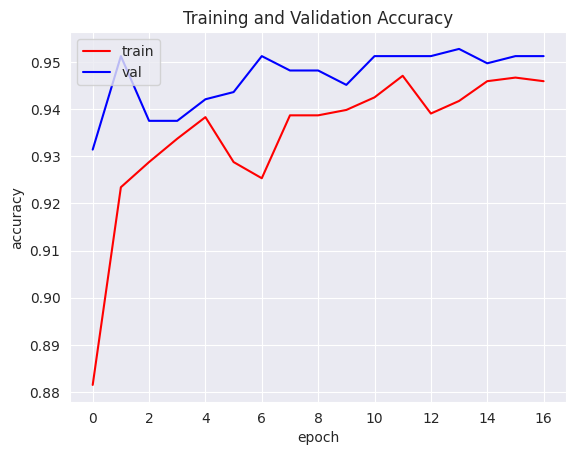

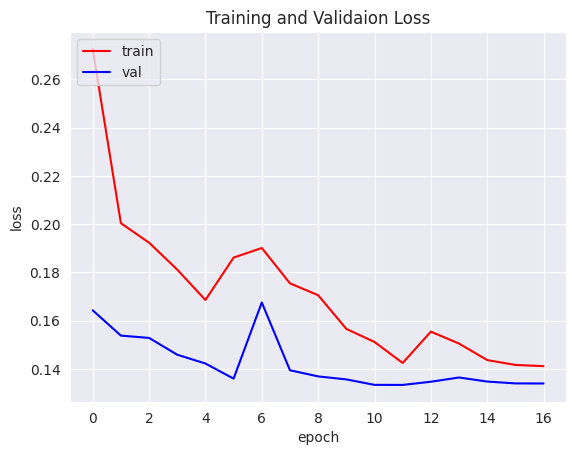

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

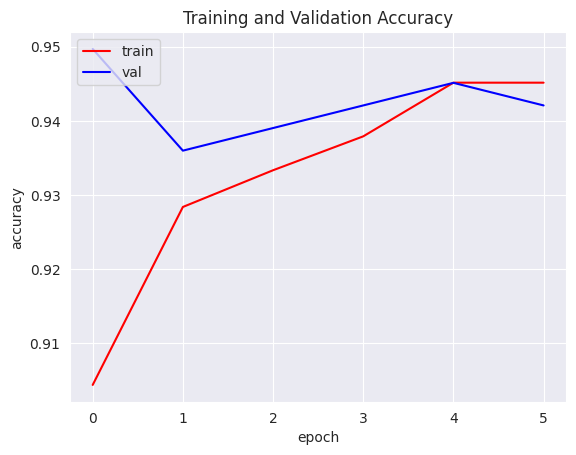

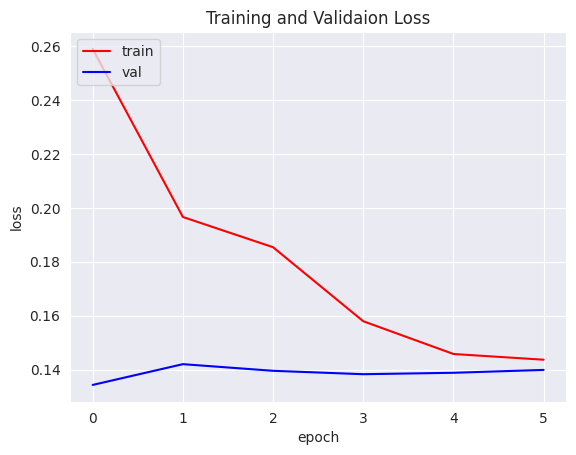

In [ ]:
# Hasil finetune MobileNetV2
acc = history_finetune.history['accuracy']
val_acc = history_finetune.history['val_accuracy']
loss = history_finetune.history['loss']
val_loss = history_finetune.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

In [ ]:
# Setelah model selesai dilatih
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc = model.evaluate(test_generator)

print(f"Akurasi Training: {train_acc * 100:.2f}%")
print(f"Akurasi Testing: {test_acc * 100:.2f}%")

42/42 ━━━━━━━━━━━━━━━━━━━━ 10s 239ms/step - accuracy: 0.9518 - loss: 0.1287
13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 536ms/step - accuracy: 0.9615 - loss: 0.1144
Akurasi Training: 95.62%
Akurasi Testing: 94.16%


In [ ]:
# Setelah model selesai dilatih dengan transfer learning MobileNetV2 (finetune)
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc = model.evaluate(test_generator)

print(f"Akurasi Training: {train_acc * 100:.2f}%")
print(f"Akurasi Testing: {test_acc * 100:.2f}%")

42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step - accuracy: 0.9578 - loss: 0.1121
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 182ms/step - accuracy: 0.9615 - loss: 0.1144
Akurasi Training: 95.62%
Akurasi Testing: 94.16%


In [ ]:
# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    img = image.load_img(image_path, target_size=(224, 224))  # Load image with target size
    img = image.img_to_array(img)  # Convert to NumPy array
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img / 255.0  # Normalize pixel values
    return img

# Load and preprocess all test images
test_images_processed = []
# Update this line to use the directory path
for class_name in os.listdir(test_dir):
    class_dir = os.path.join(test_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        test_images_processed.append(load_and_preprocess_image(image_path))

# Stack images into a single NumPy array
test_images_processed = np.vstack(test_images_processed)

# Now you can make predictions
y_pred = model.predict(test_images_processed)

26/26 ━━━━━━━━━━━━━━━━━━━━ 11s 223ms/step


In [ ]:
# Get true labels from test generator
y_true = test_generator.classes

In [ ]:
# Convert predictions to class labels (0 or 1)
y_pred_classes = (y_pred > 0.5).astype(int)

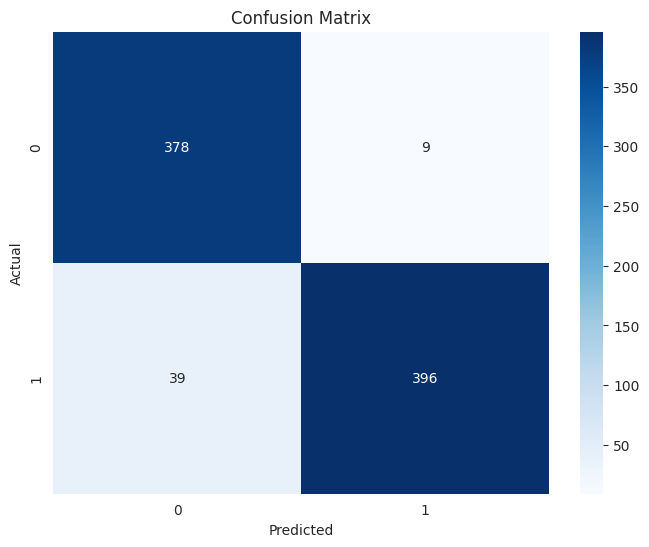

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Buat confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

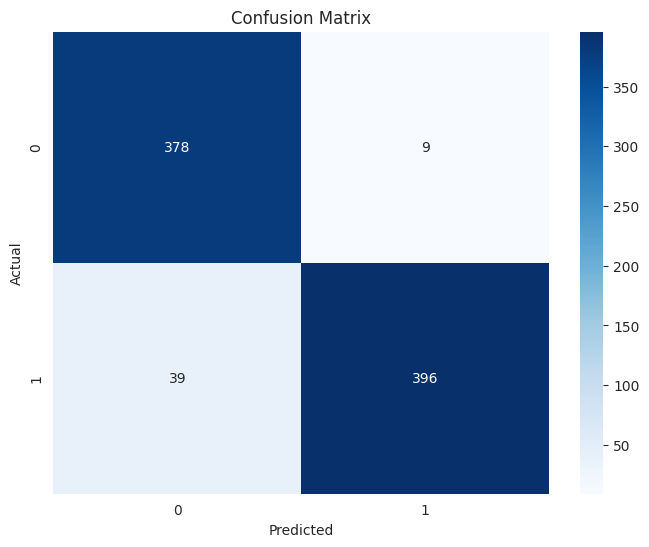

In [ ]:
# Buat confusion matrix (MobileNetV2 Fine Tuning)
cm = confusion_matrix(y_true, y_pred_classes)

# Visualisasi confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Konversi Model

In [ ]:
save_path = 'saved_model/'
tf.saved_model.save(model, save_path)

In [ ]:
model.save("model_drowsiness.h5")

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('saved_model')
tflite_model = converter.convert()

with tf.io.gfile.GFile('model_drowsiness.tflite', 'wb') as f:
    f.write(tflite_model)

In [ ]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 5.9 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [ ]:
!tensorflowjs_converter \
    --input_format=tf_saved_model \
    /content/saved_model/ \
    model_tfjs

2025-05-24 02:36:01.739135: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748054161.783627    5859 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748054161.795535    5859 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
🌲 Try https://ydf.readthedocs.io, the successor of TensorFlow Decision Forests with more features and faster training!
2025-05-24 02:36:14.018216: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1748054174.018417    5859 gpu_device.cc:2022] Created device /job:localhost/replica:0/task

In [ ]:
!zip -r model_tfjs.zip model_tfjs

  adding: model_tfjs/ (stored 0%)
  adding: model_tfjs/group1-shard1of3.bin (deflated 7%)
  adding: model_tfjs/group1-shard3of3.bin (deflated 7%)
  adding: model_tfjs/model.json (deflated 96%)
  adding: model_tfjs/group1-shard2of3.bin (deflated 7%)


In [ ]:
!zip -r saved_model.zip saved_model/

  adding: saved_model/ (stored 0%)
  adding: saved_model/fingerprint.pb (stored 0%)
  adding: saved_model/assets/ (stored 0%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.index (deflated 77%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: saved_model/saved_model.pb (deflated 90%)


## Inference

In [ ]:
# Load model
model = tf.keras.models.load_model('model_drowsiness.h5')
print("Model loaded successfully!")

Model loaded successfully!


In [ ]:
def preprocess_image(img_path):
    # Load gambar dengan ukuran 224x224 (ukuran input MobileNetV2)
    img = image.load_img(img_path, target_size=(224, 224))
    # Ubah gambar menjadi array
    img_array = image.img_to_array(img) / 255.0
    # Tambahkan dimensi batch
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

In [ ]:
def predict_eye_state(img_path):
    # Preprocessing gambar
    img_array = preprocess_image(img_path)

    # Prediksi menggunakan model
    prediction = model.predict(img_array)

    # Interpretasi hasil
    if prediction[0][0] > 0.5:
        result = "Mata Terbuka"
    else:
        result = "Mata Tertutup"

    # Visualisasi gambar
    plt.imshow(image.load_img(img_path))
    plt.title(f"Prediction: {result}")
    plt.axis('off')
    plt.show()

    return result

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


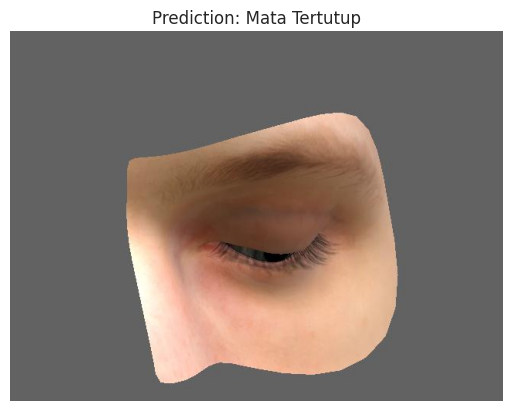

Hasil Prediksi: Mata Tertutup


In [ ]:
image_path = '/content/contoh-closed.jpg'
result = predict_eye_state(image_path)
print(f"Hasil Prediksi: {result}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step


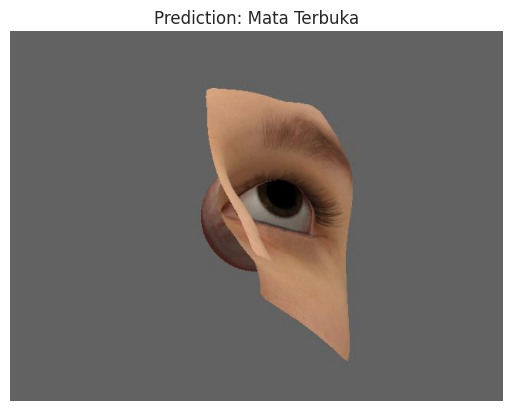

Hasil Prediksi: Mata Terbuka


In [ ]:
image_path = '/content/contoh-opened.jpg'
result = predict_eye_state(image_path)
print(f"Hasil Prediksi: {result}")